In [87]:
import ast
import pandas as pd

# Load data and preprocessing

In [156]:
#dataset = 'interference'
dataset = 'switching_interference'
dataset_url = f'https://raw.githubusercontent.com/imtezcan/carneyModelingSuperExperimentHssm/main/data/{dataset}.csv'
df = pd.read_csv(dataset_url)

In [157]:
df.head()

,Unnamed: 0,subj_id,prolific_pid,block,trial_index,file_path,task_1,cue_1_start,cue_1_dur,cue_1_end,...,or_1_start,or_1_dur,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,key_presses
0,0,WNM1zAABxWmmjSRb,6654df9e2f8447d37af7186f,train_1,0,./aw_task_switching/res/115.json,or,308.70,2300.0,2608.70,...,308.70,2300.0,2608.70,NaN,NaN,NaN,NaN,308.70,2608.70,[]
1,1,WNM1zAABxWmmjSRb,6654df9e2f8447d37af7186f,train_1,1,./aw_task_switching/res/115.json,or,3208.82,2300.0,5508.82,...,3208.82,2300.0,5508.82,NaN,NaN,NaN,NaN,3208.82,5508.82,[]
2,2,WNM1zAABxWmmjSRb,6654df9e2f8447d37af7186f,train_1,2,./aw_task_switching/res/115.json,or,6108.96,2300.0,8408.96,...,6108.96,2300.0,8408.96,NaN,NaN,NaN,NaN,6108.96,8408.96,"[{'correct': True, 'key': 'k', 'time': 6210}]"
3,3,WNM1zAABxWmmjSRb,6654df9e2f8447d37af7186f,train_1,3,./aw_task_switching/res/115.json,mov,9009.12,2300.0,11309.12,...,9009.12,2300.0,11309.12,NaN,NaN,NaN,NaN,9009.12,11309.12,[]
4,4,WNM1zAABxWmmjSRb,6654df9e2f8447d37af7186f,train_1,4,./aw_task_switching/res/115.json,mov,11909.26,2300.0,14209.26,...,11909.26,2300.0,14209.26,NaN,NaN,NaN,NaN,11909.26,14209.26,"[{'correct': False, 'key': 'j', 'time': 12538}]"


In [163]:
df['key_presses'] = df['key_presses'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [166]:
print(df[df['key_presses'].apply(len)])

KeyError: "None of [Index([ 0,  0,  1,  0,  1,  0,  0,  1,  1,  0,\n       ...\n       11,  6,  9,  3,  2,  5, 10, 12, 11,  7],\n      dtype='int64', length=75810)] are in the [columns]"

In [167]:
participants_with_10_key_presses = df[df['key_presses'].apply(len) >= 10]['subj_id'].unique()
print(participants_with_10_key_presses)


['IfyPl78YGvgbCdEp' 'O8pJqP1dBAS7cp9q' 'jXvSRLvw5IVhco9f'
 'X9QG1vmzsy8y6vOW' 'c2UY8FUR6XsO7vip' 'sI1aRlXFwj6IC9o2'
 'ZMjAPoiDzaJu6Xyg' 'I7Q2gmzPtp9byFFT' 'kTg1lmxze7FtaEyE'
 'aNaRPLBBhTMwtkFx' 'VjIsZt2iv50u2lMw' 'SctjmFZj9n9jer6g'
 'TvoQlFRsmP6Un64m' 'iLp2QzrBTxI47TOw' 'nxiWwtQaOjIIPirk'
 'W8Hm7cExSGb5IfAb' 'mBJV7kH6D306z2Oc' 'FaTw85nlNQu7vV2e'
 'XCOqoOXxlBNN9cod' 'tZhL6AM795Pyqdat' 'XNdvyppWIl6yAN19'
 'PeQ3MSxroikzVAYZ' 'qLYYzebOUPXUsz12' 'feYLgKuUSdz8QAnb'
 '7nXKMjgGdnQaBleg' 'aJVJvtcjQn1P2Q4y' 'wn3JhZ1KPHUro375'
 'WgVGGjpqEza3qpGI']


In [138]:
# Parse key presses as list of dictionaries
df['key_presses'] = df['key_presses'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# Drop rows with no key presses
#df = df[df['key_presses'].apply(lambda x: isinstance(x, list) and len(x) > 0)]
# Drop training blocks
df = df[~df['block'].str.startswith('train_')]
# Add integer participant ids
df['participant_id'] = pd.factorize(df['subj_id'])[0]
# Add number of responses
df['n_responses'] = df['key_presses'].apply(len)
# Add rt and response columns
df['rt'] = df.apply(lambda row: (row['key_presses'][0]['time'] - row['go_1_start']) / 1000 if len(row['key_presses']) > 0 else 0, axis=1)
df['response'] = df.apply(lambda row: 1.0 if len(row['key_presses']) > 0 and row['key_presses'][0]['correct'] else -1.0, axis=1)


In [139]:
# Reorder columns so that rt and response are at the front (not really necessary)
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('rt')))
cols.insert(1, cols.pop(cols.index('response')))
df = df[cols]

In [140]:
def filter_participants(df):
    valid_participants = []
    for participant_id, group in df.groupby('participant_id'):
        # Rule 1: Drop any participant who has no key presses in at least 2 trials
        if (group['n_responses'] == 0).sum() >= 2:
            continue
        
        # Rule 2: Drop any participant who has more than 2 key presses in at least 1 trial
        # if (group['n_responses'] > 2).any():
        #     continue
        
        # Rule 3: Drop any participant who has more than 2 key presses for at least half of the trials
        if (group['n_responses'] > 2).sum() > (len(group) / 2):
            continue
        
        # Rule 4: Drop any participant who has a rt (response time) of more than 2 seconds
        if (group['rt'] > 2).any():
            continue
        
        # Rule 5: Drop any participant who has a rt (response time) of 0 in any of the trials
        if (group['rt'] == 0).any():
            continue
        
        valid_participants.append(participant_id)
    
    return df[df['participant_id'].isin(valid_participants)]

# Apply the filtering function
df = filter_participants(df)

In [141]:
df.tail()

,rt,response,Unnamed: 0,subj_id,prolific_pid,block,trial_index,file_path,task_1,cue_1_start,...,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,key_presses,participant_id,n_responses
74905,0.4780,1.0,75,ukziXynylZ5vBZ4c,559c3ae1fdf99b32b55f2d33,block_4,75,./aw_task_switching/res/62.json,mov,285502.2,...,288302.2,NaN,NaN,NaN,NaN,285502.2,288302.2,"[{'correct': True, 'key': 'f', 'time': 285980....",169,1
74906,0.4351,1.0,76,ukziXynylZ5vBZ4c,559c3ae1fdf99b32b55f2d33,block_4,76,./aw_task_switching/res/62.json,mov,289305.8,...,292105.8,NaN,NaN,NaN,NaN,289305.8,292105.8,"[{'correct': True, 'key': 'j', 'time': 289740....",169,1
74907,0.5529,1.0,77,ukziXynylZ5vBZ4c,559c3ae1fdf99b32b55f2d33,block_4,77,./aw_task_switching/res/62.json,or,293102.4,...,295902.4,NaN,NaN,NaN,NaN,293102.4,295902.4,"[{'correct': True, 'key': 'd', 'time': 293655....",169,1
74908,0.6645,1.0,78,ukziXynylZ5vBZ4c,559c3ae1fdf99b32b55f2d33,block_4,78,./aw_task_switching/res/62.json,mov,296906.0,...,299706.0,NaN,NaN,NaN,NaN,296906.0,299706.0,"[{'correct': True, 'key': 'j', 'time': 297570.5}]",169,1
74909,0.5716,1.0,79,ukziXynylZ5vBZ4c,559c3ae1fdf99b32b55f2d33,block_4,79,./aw_task_switching/res/62.json,mov,300702.6,...,303502.6,NaN,NaN,NaN,NaN,300702.6,303502.6,"[{'correct': True, 'key': 'f', 'time': 301274....",169,1


In [142]:
df.describe()

,rt,response,Unnamed: 0,trial_index,cue_1_start,cue_1_dur,cue_1_end,task_2,cue_2_start,cue_2_dur,...,or_1_dur,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,participant_id,n_responses
count,10480.000000,10480.000000,10480.000000,10480.000000,10480.000000,10480.000000,10480.000000,0.0,0.0,0.0,...,10480.000000,10480.000000,0.0,0.0,0.0,0.0,10480.000000,10480.000000,10480.000000,10480.000000
mean,0.807757,0.831870,39.500000,39.500000,117670.591446,2584.274809,120254.866255,NaN,NaN,NaN,...,2584.274809,120254.866255,NaN,NaN,NaN,NaN,117670.591446,120254.866255,85.412214,1.066412
std,0.226665,0.554997,23.093308,23.093308,70620.845273,381.116497,70678.999153,NaN,NaN,NaN,...,381.116497,70678.999153,NaN,NaN,NaN,NaN,70620.845273,70678.999153,46.096837,0.273487
min,0.089100,-1.000000,0.000000,0.000000,1.000000,1845.000000,1955.300000,NaN,NaN,NaN,...,1845.000000,1955.300000,NaN,NaN,NaN,NaN,1.000000,1955.300000,4.000000,1.000000
25%,0.651300,1.000000,19.750000,19.750000,57705.950000,2300.000000,59950.500000,NaN,NaN,NaN,...,2300.000000,59950.500000,NaN,NaN,NaN,NaN,57705.950000,59950.500000,45.000000,1.000000
50%,0.764750,1.000000,39.500000,39.500000,116002.850000,2600.000000,118600.950000,NaN,NaN,NaN,...,2600.000000,118600.950000,NaN,NaN,NaN,NaN,116002.850000,118600.950000,87.000000,1.000000
75%,0.915050,1.000000,59.250000,59.250000,176103.200000,2970.000000,178902.915000,NaN,NaN,NaN,...,2970.000000,178902.915000,NaN,NaN,NaN,NaN,176103.200000,178902.915000,131.000000,1.000000
max,1.972200,1.000000,79.000000,79.000000,300707.000000,3000.000000,303507.000000,NaN,NaN,NaN,...,3000.000000,303507.000000,NaN,NaN,NaN,NaN,300707.000000,303507.000000,169.000000,4.000000


In [143]:
df.to_csv(f'data/{dataset}_preprocessed.csv', index=False)

In [144]:
df['rt']

1865     0.886909
1866     1.172032
1867     1.612332
1868     1.497332
1869     0.923555
           ...   
74905    0.478000
74906    0.435100
74907    0.552900
74908    0.664500
74909    0.571600
Name: rt, Length: 10480, dtype: float64

# Model fitting - Simple DDM model

In [145]:
# Uncomment below if using Colab
# !pip install hddm

In [146]:
import hssm
import pandas as pd
from matplotlib import pyplot as plt
import arviz as az

### Load preprocessed data

In [147]:
dataset = 'switching_interference'
df = pd.read_csv(f'data/{dataset}_preprocessed.csv')

In [148]:
df.head()

,rt,response,Unnamed: 0,subj_id,prolific_pid,block,trial_index,file_path,task_1,cue_1_start,...,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,key_presses,participant_id,n_responses
0,0.886909,1.0,0,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,0,./aw_task_switching/res/20.json,or,187.891,...,3157.891,NaN,NaN,NaN,NaN,187.891,3157.891,"[{'correct': True, 'key': 'd', 'time': 1074.79...",4,1
1,1.172032,1.0,1,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,1,./aw_task_switching/res/20.json,mov,3530.268,...,6500.268,NaN,NaN,NaN,NaN,3530.268,6500.268,"[{'correct': True, 'key': 'f', 'time': 4702.29...",4,1
2,1.612332,1.0,2,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,2,./aw_task_switching/res/20.json,mov,6872.468,...,9842.468,NaN,NaN,NaN,NaN,6872.468,9842.468,"[{'correct': True, 'key': 'f', 'time': 8484.79...",4,1
3,1.497332,1.0,3,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,3,./aw_task_switching/res/20.json,mov,10214.668,...,13184.668,NaN,NaN,NaN,NaN,10214.668,13184.668,"[{'correct': True, 'key': 'f', 'time': 11712}]",4,1
4,0.923555,1.0,4,5aLYmsSb0wjFCzSc,628667709c7e31f9018e77d5,block_1,4,./aw_task_switching/res/20.json,or,13557.045,...,16527.045,NaN,NaN,NaN,NaN,13557.045,16527.045,"[{'correct': True, 'key': 'k', 'time': 14480.5...",4,1


### Plot RTs

(-4.0, 4.0)

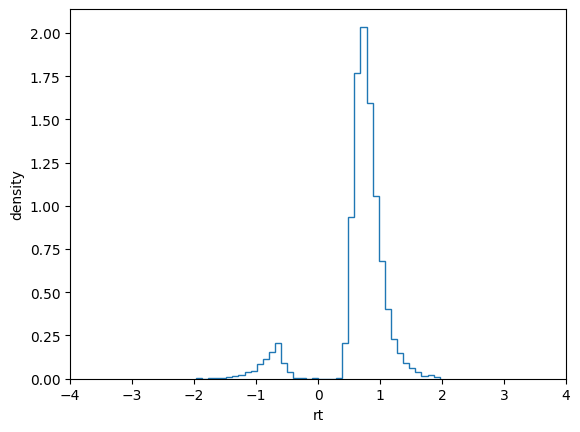

In [149]:
plt.hist(df['rt'] * df['response'],
         histtype='step', bins = 40, density=True)
plt.xlabel('rt')
plt.ylabel('density')
plt.xlim(-4, 4)

### Create a simple DDM model

In [101]:
subset_df = df.sample(n=1000, random_state=42)  # Sample 1000 rows for the smaller dataset

# Check the sampled data
print(subset_df.describe())
print(subset_df.head())


                rt     response   Unnamed: 0  trial_index    cue_1_start  \
count  1000.000000  1000.000000  1000.000000  1000.000000    1000.000000   
mean      0.963897     0.544000    39.473000    39.473000  115251.142278   
std       0.394804     0.839505    23.132453    23.132453   70134.466483   
min       0.006300    -1.000000     0.000000     0.000000       4.000000   
25%       0.728450     1.000000    20.000000    20.000000   57477.625000   
50%       0.894800     1.000000    39.000000    39.000000  111622.450000   
75%       1.144025     1.000000    59.000000    59.000000  169704.255000   
max       2.616520     1.000000    79.000000    79.000000  296916.100000   

         cue_1_dur      cue_1_end  task_2  cue_2_start  cue_2_dur  ...  \
count  1000.000000    1000.000000     0.0          0.0        0.0  ...   
mean   2500.910000  117752.052278     NaN          NaN        NaN  ...   
std     411.506026   70209.285962     NaN          NaN        NaN  ...   
min    1845.000000 

In [115]:
(df['rt'] == 0).sum()

0

In [120]:
df.describe()

,rt,response,Unnamed: 0,trial_index,cue_1_start,cue_1_dur,cue_1_end,task_2,cue_2_start,cue_2_dur,...,or_1_dur,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,participant_id,n_responses
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,0.0,0.0,0.0,...,2880.000000,2880.000000,0.0,0.0,0.0,0.0,2880.000000,2880.000000,2880.000000,2880.000000
mean,0.825777,0.931250,39.500000,39.500000,118356.426889,2457.222222,120813.649111,NaN,NaN,NaN,...,2457.222222,120813.649111,NaN,NaN,NaN,NaN,118356.426889,120813.649111,95.555556,1.028819
std,0.240495,0.364444,23.096217,23.096217,71898.745333,361.149884,71973.417132,NaN,NaN,NaN,...,361.149884,71973.417132,NaN,NaN,NaN,NaN,71898.745333,71973.417132,48.657100,0.167328
min,0.371100,-1.000000,0.000000,0.000000,101.680000,1845.000000,1955.700000,NaN,NaN,NaN,...,1845.000000,1955.700000,NaN,NaN,NaN,NaN,101.680000,1955.700000,24.000000,1.000000
25%,0.661150,1.000000,19.750000,19.750000,57653.540000,2300.000000,60213.075000,NaN,NaN,NaN,...,2300.000000,60213.075000,NaN,NaN,NaN,NaN,57653.540000,60213.075000,53.000000,1.000000
50%,0.781240,1.000000,39.500000,39.500000,116029.850000,2300.000000,118456.200000,NaN,NaN,NaN,...,2300.000000,118456.200000,NaN,NaN,NaN,NaN,116029.850000,118456.200000,91.000000,1.000000
75%,0.939670,1.000000,59.250000,59.250000,175502.210000,2800.000000,178352.210000,NaN,NaN,NaN,...,2800.000000,178352.210000,NaN,NaN,NaN,NaN,175502.210000,178352.210000,145.000000,1.000000
max,1.944300,1.000000,79.000000,79.000000,300707.000000,3000.000000,303507.000000,NaN,NaN,NaN,...,3000.000000,303507.000000,NaN,NaN,NaN,NaN,300707.000000,303507.000000,169.000000,2.000000


In [127]:
df['participant_id'].drop_duplicates()

0        24
320      41
640      53
960      85
1280     91
1600     98
1920    145
2240    154
2560    169
Name: participant_id, dtype: int64

In [126]:
sampled_participants = df['participant_id'].drop_duplicates().sample(n=10, random_state=42)

# Filter the DataFrame to include only the sampled participants
subset_df = df[df['participant_id'].isin(sampled_participants)]

ValueError: Cannot take a larger sample than population when 'replace=False'

In [150]:
df['participant_id'].nunique()

33

In [132]:
df.describe()

,rt,response,Unnamed: 0,trial_index,cue_1_start,cue_1_dur,cue_1_end,task_2,cue_2_start,cue_2_dur,...,or_1_dur,or_1_end,or_2_coherence,or_2_start,or_2_dur,or_2_end,trial_start,trial_end,participant_id,n_responses
count,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,2880.000000,0.0,0.0,0.0,...,2880.000000,2880.000000,0.0,0.0,0.0,0.0,2880.000000,2880.000000,2880.000000,2880.000000
mean,0.825777,0.931250,39.500000,39.500000,118356.426889,2457.222222,120813.649111,NaN,NaN,NaN,...,2457.222222,120813.649111,NaN,NaN,NaN,NaN,118356.426889,120813.649111,95.555556,1.028819
std,0.240495,0.364444,23.096217,23.096217,71898.745333,361.149884,71973.417132,NaN,NaN,NaN,...,361.149884,71973.417132,NaN,NaN,NaN,NaN,71898.745333,71973.417132,48.657100,0.167328
min,0.371100,-1.000000,0.000000,0.000000,101.680000,1845.000000,1955.700000,NaN,NaN,NaN,...,1845.000000,1955.700000,NaN,NaN,NaN,NaN,101.680000,1955.700000,24.000000,1.000000
25%,0.661150,1.000000,19.750000,19.750000,57653.540000,2300.000000,60213.075000,NaN,NaN,NaN,...,2300.000000,60213.075000,NaN,NaN,NaN,NaN,57653.540000,60213.075000,53.000000,1.000000
50%,0.781240,1.000000,39.500000,39.500000,116029.850000,2300.000000,118456.200000,NaN,NaN,NaN,...,2300.000000,118456.200000,NaN,NaN,NaN,NaN,116029.850000,118456.200000,91.000000,1.000000
75%,0.939670,1.000000,59.250000,59.250000,175502.210000,2800.000000,178352.210000,NaN,NaN,NaN,...,2800.000000,178352.210000,NaN,NaN,NaN,NaN,175502.210000,178352.210000,145.000000,1.000000
max,1.944300,1.000000,79.000000,79.000000,300707.000000,3000.000000,303507.000000,NaN,NaN,NaN,...,3000.000000,303507.000000,NaN,NaN,NaN,NaN,300707.000000,303507.000000,169.000000,2.000000


In [151]:
basic_ddm_model = hssm.HSSM(data=df, model='ddm')
basic_ddm_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 10480

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

### Sample from the basic model

In [155]:
basic_ddm_model_sample = basic_ddm_model.sample(
    sampler="nuts_numpyro",
    cores=4,
    chains=4,
    draws=2500,
    tune=1500,
    idata_kwargs=dict(log_likelihood=False)
)

The model has already been sampled. Overwriting the previous inference object. Any previous reference to the inference object will still point to the old object.


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


KeyboardInterrupt



### Posterior predictive checks

In [153]:
az.summary(basic_ddm_model_sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.821,0.024,1.781,1.866,0.002,0.001,210.0,469.0,1.03
t,0.088,0.001,0.087,0.089,0.000,0.000,308.0,665.0,1.02
v,3.991,0.038,3.916,4.057,0.004,0.003,99.0,334.0,1.04
z,0.213,0.008,0.200,0.227,0.000,0.000,283.0,599.0,1.02


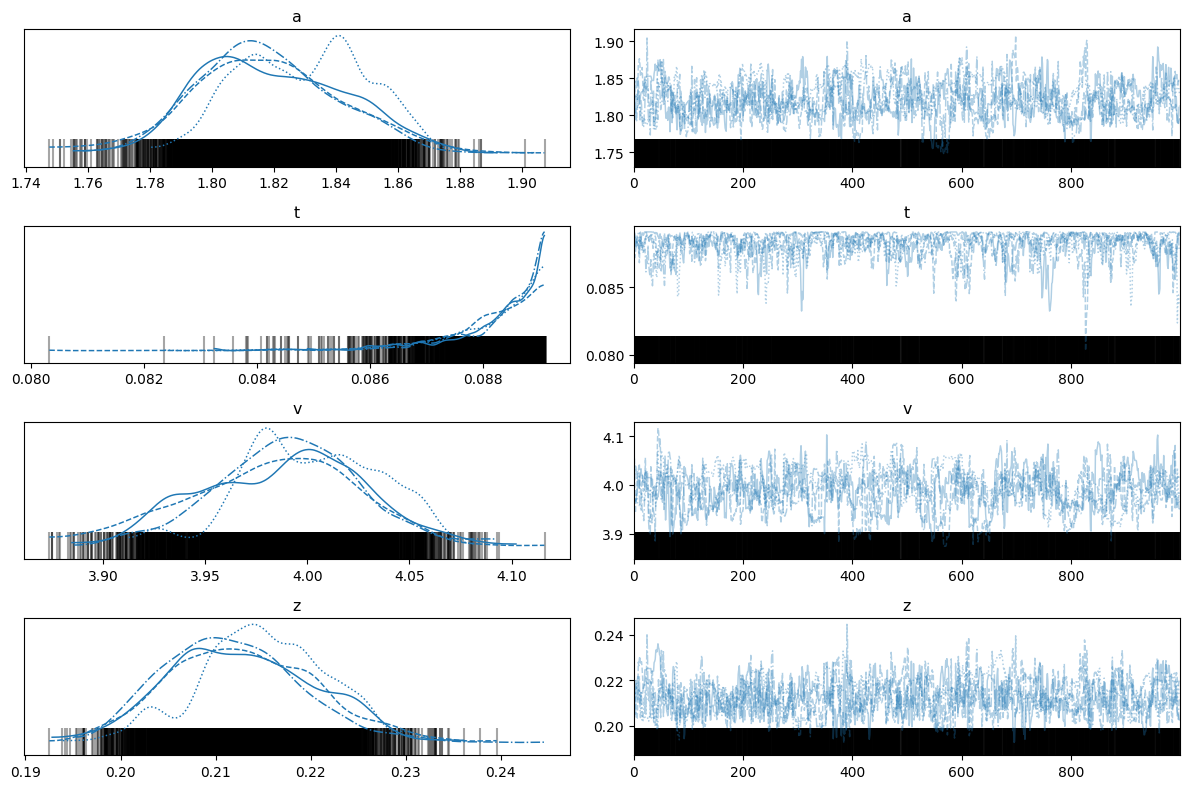

In [154]:
az.plot_trace(
    basic_ddm_model_sample
)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

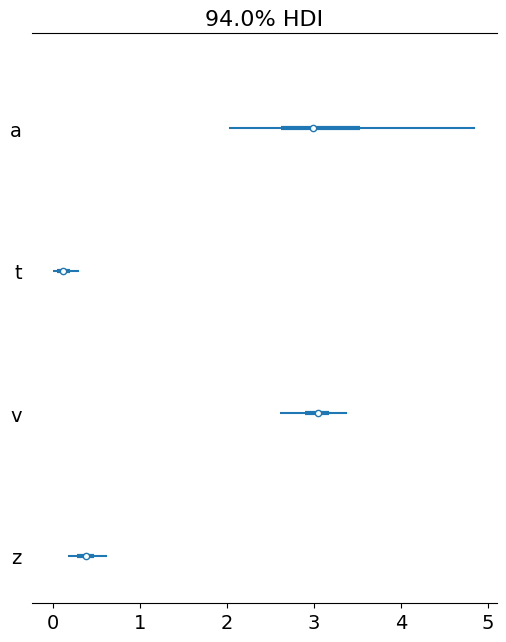

In [132]:
az.plot_forest(basic_ddm_model_sample, combined=True)

In [71]:
print('###Describe data###')
print(df.describe())  # Check summary statistics
print('###How many NaN?###')
print(df.isna().sum())  # Check for missing values

###Describe data###
                 rt      response    Unnamed: 0   trial_index    cue_1_start  \
count  72242.000000  72242.000000  72242.000000  72242.000000   72242.000000   
mean       1.024821      0.537693     37.450223     37.450223  110975.646863   
std        0.436639      0.843147     22.130385     22.130385   68255.836106   
min        0.000000     -1.000000      0.000000      0.000000       0.000000   
25%        0.745000      1.000000     18.000000     18.000000   53636.050000   
50%        0.945133      1.000000     37.000000     37.000000  107312.100000   
75%        1.238500      1.000000     56.000000     56.000000  162714.000000   
max        2.997000      1.000000     79.000000     79.000000  300725.400000   

          cue_1_dur      cue_1_end  task_2  cue_2_start  cue_2_dur  ...  \
count  72242.000000   72242.000000     0.0          0.0        0.0  ...   
mean    2528.566000  113504.212863     NaN          NaN        NaN  ...   
std      396.306264   68328.837963

In [ ]:
df['rt']

In [72]:
print(df['rt'].nunique())  # Number of unique reaction times
print(df['response'].nunique())  # Number of unique responses


61116
2


In [73]:
len(df)

72242

## Complex HSSM models
Ok this sucked. Let's try a more complex model. We will try a hierarchical model. 

In [117]:
subset_df = df[df['participant_id'] < 10]

In [81]:
hierarchical_model = hssm.HSSM(
    data=subset_df,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.,
                    "sigma": 0.5,
                    "initval": 0.2,
                }
            },
            "formula": "v ~ 1 + (1|participant_id)",
            "link": "identity",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 4.0
                }
            },
            "formula": "a ~ 1 + (1|participant_id)",
            "link": "identity",
        },
        {
            "name": "z",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": 0.0,
                    "upper": 1.0,
                    "initval": 0.5,
                }
            },
            "formula": "z ~ 1 + (1|participant_id)",
            "link": "identity",
        },
        {
            "name": "t",
            "prior": {
                "Intercept": {
                    "name": "HalfNormal",
                    "sigma": 2.0
                }
            },
            "formula": "t ~ 1 + (1|participant_id)",
            "link": "identity",
        }        
    ],
)

In [82]:
hierarchical_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 3127

Parameters:

v:
    Formula: v ~ 1 + (1|participant_id)
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 0.5, initval: 0.2)
        v_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Formula: a ~ 1 + (1|participant_id)
    Priors:
        a_Intercept ~ HalfNormal(sigma: 4.0)
        a_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, inf)

z:
    Formula: z ~ 1 + (1|participant_id)
    Priors:
        z_Intercept ~ Uniform(lower: 0.0, upper: 1.0, initval: 0.5)
        z_1|participant_id ~ Normal(mu: 0.0, sigma: Weibull(alpha: 1.5, beta: 0.3))
    Link: identity
    Explicit bounds: (0.0, 1.0)

t:
    Formula: t ~ 1 + (1|participant_id)
    Priors:
        t_Intercept ~ HalfNormal(sigma: 2.0)
        t_1

In [83]:
infer_data_hierarchical = hierarchical_model.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=2500,
    tune=1500,
    idata_kwargs=dict(log_likelihood=False)
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/imtezcan/Repositories/CogSci/Brown2024/modeling-challenge-switching-hssm/modelingChallengeSwitchingHssm/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 5000 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [80]:
az.summary(infer_data_hierarchical)

/Users/imtezcan/Repositories/CogSci/Brown2024/modeling-challenge-switching-hssm/modelingChallengeSwitchingHssm/.venv/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_1|participant_id[0],-0.002,0.0,-0.002,-0.002,0.0,0.0,5000.0,5000.0,NaN
a_1|participant_id[1],0.002,0.0,0.002,0.002,0.0,0.0,5000.0,5000.0,NaN
a_1|participant_id[2],-0.000,0.0,-0.000,-0.000,0.0,0.0,5000.0,5000.0,NaN
a_1|participant_id[3],0.002,0.0,0.002,0.002,0.0,0.0,5000.0,5000.0,NaN
a_1|participant_id[4],0.002,0.0,0.002,0.002,0.0,0.0,5000.0,5000.0,NaN
...,...,...,...,...,...,...,...,...,...
z[3122],0.500,0.0,0.500,0.500,0.0,0.0,5000.0,5000.0,NaN
z[3123],0.500,0.0,0.500,0.500,0.0,0.0,5000.0,5000.0,NaN
z[3124],0.500,0.0,0.500,0.500,0.0,0.0,5000.0,5000.0,NaN
z[3125],0.500,0.0,0.500,0.500,0.0,0.0,5000.0,5000.0,NaN


In [76]:
az.plot_trace(infer_data_hierarchical)

/Users/imtezcan/Repositories/CogSci/Brown2024/modeling-challenge-switching-hssm/modelingChallengeSwitchingHssm/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/imtezcan/Repositories/CogSci/Brown2024/modeling-challenge-switching-hssm/modelingChallengeSwitchingHssm/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/imtezcan/Repositories/CogSci/Brown2024/modeling-challenge-switching-hssm/modelingChallengeSwitchingHssm/.venv/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values"

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x17980f1c0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x34e9ca560> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

